## Necessary import

In [1]:
import numpy as np
import scipy.io as sio
from tqdm.notebook import tqdm, trange
import os
import warnings
import numpy as np
from pyhht import EMD
from scipy.stats import entropy

## Data Collection

In [5]:
data_dir = "D://Charan_Project//SEED//SEED//SEED_EEG//Preprocessed_EEG"
output_dir = "D://Charan_Project//output_dir"
baseline_removal_window = 3
cutoff_frequencies = [2,45]
downsampling_rate = 128
window_size = 4
window_overlap = 2
save_plots_to_file = False

The SEED dataset contains 3 types of emotion (positive, neutral,negative) EEG data. The sampling frequency is 200Hz and the number of experiments in each category remains the same. In each experiment, 62 channels of EEG data were recorded according to the international standard 10-20 system.

In [3]:
sampling_rate = 200
channel_names = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']


In [4]:
from glob import glob
def get_session_id(subject_id,filename):
    #print(os.path.join(data_dir,subject_id,'_********.mat'))
    files = glob(os.path.join(data_dir,subject_id+'_********.mat'))
    return sorted(files).index(os.path.join(data_dir,filename))

In [5]:
def get_keynames(dict_keys):
    dict_keys = list(dict_keys)
    trial_names = list()
    for trial_name in dict_keys:
        for i in range(1,16):
            if '_eeg'+str(i) in trial_name:
                trial_names.append(trial_name)
    return trial_names

In [6]:
label = sio.loadmat(r'D://Charan_Project//SEED//SEED//SEED_EEG//ExtractedFeatures//label')['label'][0]
print(label)
print(len(label))

[ 1  0 -1 -1  0  1 -1  0  1  1  0 -1  0  1 -1]
15


In [7]:
X = np.zeros((675,62,53001))
X_len = np.zeros(675,dtype=int)
Y = np.zeros((675,))
session = np.zeros((675,))
subject = np.zeros((675,))
trial = np.zeros((675,))
for file in tqdm(os.listdir(data_dir)):
    if file.endswith(".mat") and not file.endswith("label.mat"):
        subject_id = file.split('_')[0]
        session_id = get_session_id(subject_id,file)
        X_temp = sio.loadmat(os.path.join(data_dir,file))
        X_temp_keys = get_keynames(X_temp.keys())
        for trial_id in range(1,16):
            experiment_id = session_id*15*15 + (int(subject_id)-1)*15 + trial_id-1
            subject[experiment_id] = subject_id
            session[experiment_id] = session_id
            trial[experiment_id] = trial_id
            Y[experiment_id] = label[trial_id-1]
            X_temp_exp = X_temp[X_temp_keys[trial_id]]
            X_len[experiment_id] = X_temp_exp.shape[1]
            X[experiment_id,:,:X_temp_exp.shape[1]] = X_temp_exp

  0%|          | 0/47 [00:00<?, ?it/s]

Each experiment consisted of an EEG recording lasting about four minutes. Each subject conducted 15 experiments in each time period. Therefore, each subject has a
total of 45 (15*3) experiments, including 15 positive emotion experiments and 15 negative emotion experiments. In our paper, we use only positive and negative emotion experiments
to assess the ability of subject-independent emotion recognition

In [8]:
import numpy as np

# Y contains labels (1 for positive, 0 for neutral, -1 for negative)
# Create a mask to select non-neutral experiments
mask = (Y != 0)

# Use the mask to select only non-neutral experiments in X
# 
X_non_neutral = X[mask]


In [9]:
X=X_non_neutral
Y=Y[mask]
print(X.shape)  #
print(Y.shape)

(450, 62, 53001)
(450,)


In [10]:
print("Shape of the Time Series Array X: " + str(X.shape))
print("Unique Label Y Indices: " + str(np.unique(Y)))
print("Unique Session Indices: " + str(np.unique(session)))
print("Unique Subject Indices: " + str(np.unique(subject)))
print("Unique Trial Indices: " + str(np.unique(trial)))
print("Minimum length of Timeseries: " + str(min(X_len)))
print("Maximum length of Timeseries: " + str(max(X_len)))

Shape of the Time Series Array X: (450, 62, 53001)
Unique Label Y Indices: [-1.  1.]
Unique Session Indices: [0. 1. 2.]
Unique Subject Indices: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
Unique Trial Indices: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
Minimum length of Timeseries: 37001
Maximum length of Timeseries: 53001


In [11]:
# X_raw is later used for plotting, if you don't want to see the plots, you can uncomment this line
X_raw = X.copy()

In [12]:
if not(baseline_removal_window==0):
    baseline_datapoints = baseline_removal_window * sampling_rate
    baseline = X[:,:,:baseline_datapoints].sum(2) / baseline_datapoints
    for timestep in trange(X.shape[2]):
        X[:,:,timestep] = X[:,:,timestep] - baseline

  0%|          | 0/53001 [00:00<?, ?it/s]

## Filtering

In [13]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, btype='band', order=5):
        nyq = 0.5 * fs
        if btype == 'bandpass':
            low = lowcut / nyq
            high = highcut / nyq
            sos = butter(order, [low, high], analog=False, btype='bandpass', output='sos')
        elif btype == 'highpass':
            low = lowcut / nyq
            sos = butter(order, low, analog=False, btype='highpass', output='sos')
        elif btype == 'lowpass':
            high = highcut / nyq
            sos = butter(order, high, analog=False, btype='lowpass', output='sos')
        return sos

def butter_bandpass_filter(X, lowcut, highcut, fs, btype='bandpass', order=5):
        sos = butter_bandpass(lowcut, highcut, fs, btype=btype, order=order)
        X = sosfilt(sos, X)
        return X

In [14]:
if not(cutoff_frequencies[0] == None):
    if not(cutoff_frequencies[1] == None):
        btype='bandpass'
    else:
        btype='highpass'
elif not (cutoff_frequencies[1] == None):
        btype='lowpass'

for experiment_id in trange(X.shape[0]):
    for channel_id in range(X.shape[1]):
        X[experiment_id, channel_id, :] = butter_bandpass_filter(
                                                        X[experiment_id, channel_id, :],
                                                        cutoff_frequencies[0],
                                                        cutoff_frequencies[1],
                                                        sampling_rate,
                                                        btype=btype,
                                                        order=5)

  0%|          | 0/450 [00:00<?, ?it/s]

## Segmenting

After preprocessing the EEG signals, we select 60-second EEG signals (from the first 0.5s to 60.5s) for each experiment

In [15]:
# Define the desired segment start and end times
segment_start_time = 0.5  # Start time in seconds
segment_end_time = 60.5   # End time in seconds

# Calculate the corresponding sample indices for the segment
segment_start_index = int(segment_start_time * sampling_rate)
segment_end_index = int(segment_end_time * sampling_rate)

# Initialize an array to store the selected EEG segments
X_selected = np.zeros((X.shape[0], X.shape[1], segment_end_index - segment_start_index))

# Iterate through each experiment and select the desired segment
for exp_id in trange(X.shape[0]):  # Use X.shape[0] to iterate over the available experiments
    # Extract the segment for each channel
    X_selected[exp_id, :, :] = X[exp_id, :, segment_start_index:segment_end_index]

# Update X with the selected segments
X = X_selected



  0%|          | 0/450 [00:00<?, ?it/s]

In [16]:
X.shape #(15subjects, 62channels, 60seconds*200samples/second)

(450, 62, 12000)

In [17]:
total_signal_duration = 60  # 60 seconds
window_size = 4  # 4 seconds
window_overlap = 2  # 2 seconds

effective_window_size = window_size - window_overlap
number_of_windows = (total_signal_duration - effective_window_size) / effective_window_size

print("Number of windows:", int(number_of_windows))


Number of windows: 29


In [18]:
X.shape

(450, 62, 12000)

# Cut into windows

In [19]:
import numpy as np

# Define parameters
sampling_rate = 200  # Replace with your actual sampling rate
signal_duration = 60  # Duration of the original EEG signal in seconds
window_size = 4  # Duration of each window in seconds
overlap = 2  # Overlap between consecutive windows in seconds

# Calculate the number of data points in each window
window_size_samples = window_size * sampling_rate
overlap_samples = overlap * sampling_rate

# Calculate the number of windows
num_windows = int((signal_duration - window_size) / overlap) + 1

# Initialize an array to store the segmented EEG data
X_data = np.zeros((X.shape[0], X.shape[1], num_windows, window_size_samples))

# Iterate through each experiment
for experiment_id in range(X.shape[0]):
    for channel_id in range(X.shape[1]):
        for window_id in range(num_windows):
            # Calculate the start and end indices for each window
            start_index = window_id * overlap_samples
            end_index = start_index + window_size_samples
            
            # Extract the data for the current window
            window_data = X[experiment_id, channel_id, start_index:end_index]
            
            # Store the windowed data in the segmented array
            X_data[experiment_id, channel_id, window_id, :] = window_data


In [20]:
X_data.shape

(450, 62, 29, 800)

In [28]:
users_windows=X_data.reshape(15,53940,800)

## EMD

In [30]:
# List to store participant DDE features arrays
subject_dde_features = []

# Counter for windows with IMF features less than 5
windows_with_less_than_5_imfs = 0

for user_windows in users_windows:
    # List to store DDE features for each window
    dde_features = []

    for window in user_windows:
        #Apply EMD to the window
        decomposer = EMD(window,n_imfs=4) #Provide input data and number of IMFs to decompose
        imfs = decomposer.decompose() #Decompose the signal into IMFs

        # Calculate differential entropy for each IMF
        imf_dde = []
        for imf in imfs:
            p_density = np.histogram(imf, density=True)[0]
            dde = -np.sum(p_density * np.log2(p_density + 1e-10))
            imf_dde.append(dde)
        
        # Pad or truncate IMF features to make them consistent
        while len(imf_dde) < 5:
            imf_dde.append(0.0)  # Pad with zeros
        
        # Append the DDE values for this window to the features list
        dde_features.append(imf_dde)
        
        if len(imf_dde) < 5:
            windows_with_less_than_5_imfs += 1
    
    # Convert the DDE features list to a numpy array
    dde_features_array = np.array(dde_features)

    # Reshape the array to (40,1,29,160)
    dde_features_array_reshaped = dde_features_array.reshape(30,1,29,310)

    #Append the DDE features array for this participant to the list
    subject_dde_features.append(dde_features_array_reshaped)

# Save the reshaped arrays for each participant
for i,dde_features_array in enumerate(subject_dde_features):
    participant_id = i+1
    np.save(f'subj_{participant_id}_dde_features.npy', dde_features_array)



print(f"Number of windows with IMF features less than 5: {windows_with_less_than_5_imfs}")


Mode 4, Iteration 600
1 minima > 0; 12 maxima < 0.
Mode 4, Iteration 800
1 minima > 0; 12 maxima < 0.
Mode 4, Iteration 1000
1 minima > 0; 12 maxima < 0.
Mode 4, Iteration 1200
1 minima > 0; 12 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 11 maxima < 0.
Mode 4, Iteration 800
1 minima > 0; 11 maxima < 0.
Mode 4, Iteration 1000
1 minima > 0; 11 maxima < 0.
Mode 4, Iteration 1200
1 minima > 0; 11 maxima < 0.
Mode 4, Iteration 1400
1 minima > 0; 11 maxima < 0.
Mode 4, Iteration 1600
1 minima > 0; 11 maxima < 0.
Mode 4, Iteration 1800
1 minima > 0; 11 maxima < 0.


c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyhht\emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 4, Iteration 600
1 minima > 0; 15 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 14 maxima < 0.
Mode 4, Iteration 800
1 minima > 0; 13 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 4, Iteration 800
1 minima > 0; 7 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 23 maxima < 0.
Mode 3, Iteration 600
0 minima > 0; 29 maxima < 0.
Mode 3, Iteration 600
0 minima > 0; 23 maxima < 0.
Mode 3, Iteration 600
1 minima > 0; 38 maxima < 0.
Mode 4, Iteration 800
0 minima > 0; 30 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 3, Iteration 600
1 minima > 0; 26 maxima < 0.
Mode 3, Iteration 800
0 minima > 0; 29 maxima < 0.
Mode 4, Iteration 1000
1 minima > 0; 19 maxima < 0.
Mode 3, Iteration 600
0 minima > 0; 32 maxima < 0.
Mode 4, Iteration 800
0 minima > 0; 19 maxima < 0.
Mode 4, Iteration 1000
0 minima > 0; 16 maxima < 0.
Mode 4, Iteration 600
2 minima > 0; 16 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 23 maxima < 0.
Mode 4, Iteration 800
1 minima 

In [34]:
import numpy as np

# Load the saved DDE features array for subj_1
dde_features_array_subj_1 = np.load('subj_1_dde_features.npy')
dde_features_array_subj_15 = np.load('subj_15_dde_features.npy')
dde_features_array_subj_7 = np.load('subj_7_dde_features.npy')

# Print the shape of the loaded array
print("Shape of dde_features_array_subj_1:", dde_features_array_subj_1.shape)
print("Shape of dde_features_array_subj_15:", dde_features_array_subj_15.shape)

print(dde_features_array_subj_1)




Shape of dde_features_array_subj_1: (30, 1, 29, 310)
Shape of dde_features_array_subj_15: (30, 1, 29, 310)
[[[[1.70640315 0.46526853 0.73524463 ... 1.02078512 1.95839666
    2.72232032]
   [1.44243384 2.17986765 2.18519658 ... 2.49368649 1.54348428
    1.69560073]
   [2.48020655 2.13059011 1.20333371 ... 2.05192439 2.47285557
    2.85720618]
   ...
   [0.01646657 0.00736296 0.01288483 ... 1.97541015 2.03620764
    3.24157335]
   [0.9919827  1.64909742 1.61544864 ... 2.48826936 2.34737786
    4.32535093]
   [1.6922135  1.30420124 2.15989452 ... 1.98114634 2.14297139
    3.79370625]]]


 [[[1.71024643 0.83440695 0.62225057 ... 0.614813   0.9352578
    1.27971788]
   [1.68388964 1.08612112 0.75734033 ... 1.25112714 1.22739977
    2.79644751]
   [1.60256267 1.64983789 1.3157843  ... 0.94429125 1.3655407
    2.75446204]
   ...
   [0.005433   0.0089034  0.00499799 ... 1.55432573 2.68756879
    2.43712319]
   [1.23728828 1.59777048 1.21391949 ... 1.67333598 2.29189198
    3.08734652]
   [2.05

In [35]:
print(dde_features_array_subj_7)

[[[[1.78480057 1.47530438 1.77929702 ... 1.34598042 2.57553957
    2.38292704]
   [1.60298372 1.31728979 0.77939556 ... 1.60579125 2.0764726
    3.38178152]
   [1.83299348 1.64547495 2.20680908 ... 0.85737707 1.12624488
    2.14346875]
   ...
   [1.46397807 1.9410065  1.94480832 ... 2.07710951 2.98836784
    2.94205773]
   [1.64657171 0.77014283 0.738265   ... 2.58144476 2.80134655
    3.4567455 ]
   [1.44815448 2.54407561 3.28625934 ... 1.72410479 2.80650785
    3.37659771]]]


 [[[1.72602857 2.37684782 1.87633154 ... 2.12763046 2.66260938
    3.90966656]
   [1.80429282 1.98567542 1.49539354 ... 3.37908668 2.55376623
    3.13112002]
   [2.23745377 1.98374407 2.31208901 ... 2.41565789 3.074308
    4.60730707]
   ...
   [2.26142986 1.80621763 1.70328009 ... 2.12961962 3.11193768
    4.47305972]
   [1.02335188 1.27044112 1.51092303 ... 1.78785249 2.0638982
    4.65329989]
   [1.58598022 2.11539687 2.58527288 ... 1.82744942 3.28187807
    3.02344824]]]


 [[[1.99650856 2.24661867 1.402413

In [42]:
# Load participant DDE features
participant_dde_features = []  # List to store participant DDE features arrays
for i in range(1,16):
    dde_features_array = np.load(f'subj_{i}_dde_features.npy')
    participant_dde_features.append(dde_features_array)
participant_dde_features = np.array(participant_dde_features)


In [286]:
X= participant_dde_features.reshape(15,30,29,310)
X.shape

(15, 30, 29, 310)

In [40]:
from collections import Counter
cnt=Counter(Y)
print(cnt)

Counter({1.0: 225, -1.0: 225})


In [287]:
Y=Y.reshape(15,30)

## MODEL TRAINING

In [62]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from keras import layers, models
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import KFold
import scikeras
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping

In [67]:
def create_cnn_model1(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Specify the number of classes here
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model




In [59]:
num_subjects = participant_dde_features.shape[0]
num_trials = participant_dde_features.shape[1]
num_classes = 2 # 2 classes for quadrants

# Reshape the data to fit the CNN input shape
input_shape = (participant_dde_features.shape[2], participant_dde_features.shape[3],1)  #(29,310,1)

# Initialize KFold cross-validation
kf = KFold(n_splits=num_subjects)

# Placeholder for storing accuracy scores
accuracy_scores = []

# Placeholder for storing loss history
loss_history = []

# Initialize the Early Stopping callback with adjusted patience and monitoring metric
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)


# Iterate through each subject as the test set
for train_subjects, test_subjects in kf.split(np.arange(num_subjects)):
    # Select data for training and testing
    X_train = participant_dde_features[train_subjects].reshape(-1, *input_shape)
    y_train = Y[train_subjects].flatten()
    
    X_test = participant_dde_features[test_subjects].reshape(-1, *input_shape)
    y_test = Y[test_subjects].flatten()
    
    # Create the CNN model
    model = create_cnn_model2(input_shape,num_classes)
    
    # Apply Early Stopping and Learning Rate Annealing
    early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
    
    # Train the model with callbacks
    history = model.fit(X_train, y_train, epochs=1000, batch_size=32,
                                 validation_split=0.2, callbacks=[early_stopping, lr_reduction], verbose=1)
    

    # Append loss and accuracy history to the lists
    loss_history.append(history.history['loss'])

    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred_classes)
    accuracy_scores.append(accuracy)


    # Plot loss and accuracy curves for this fold
    plt.figure(figsize=(12, 4))

    # Plot training and validation loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Calculate the average accuracy
average_accuracy = np.mean(accuracy_scores)
print("Average Classification Accuracy:", average_accuracy)


ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_3. Consider increasing the input size. Received input shape [None, 1, 29, 310] which would produce output shape with a zero or negative value in a dimension.

## GRID SEARCH

In [148]:
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
import scikeras
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import make_scorer
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

# Define a wrapper class for KerasClassifier that includes dropout_rate
class MyKerasClassifier(KerasClassifier):
    def __init__(self, dropout_rate=0.2, kernel_regularizer=None, **kwargs):
        self.dropout_rate = dropout_rate
        self.kernel_regularizer = kernel_regularizer
        super().__init__(**kwargs)

    def build_fn(self):
        return create_cnn_model(dropout_rate=self.dropout_rate, kernel_regularizer=self.kernel_regularizer)

# Define your CNN model as a function
def create_cnn_model(dropout_rate=0.5, kernel_regularizer=None):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(29, 310, 1)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    if kernel_regularizer:
        model.add(Dense(1024, activation='relu', kernel_regularizer=kernel_regularizer))
    else:
        model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax'))  # Output layer with 2 units and softmax activation
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'dropout_rate': [0.25, 0.5],
    'kernel_regularizer': [None, tf.keras.regularizers.l2(0.01)],
    'batch_size': [32, 64],
    'epochs': [100, 200]
}

# Create a KerasClassifier wrapper for scikit-learn
model = MyKerasClassifier(build_fn=create_cnn_model, epochs=10, batch_size=32, verbose=0)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(accuracy_score), cv=kf)

# Define the scorer for GridSearchCV
scorer = make_scorer(accuracy_score)

# Create a KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Fit the grid search to the data
grid_result = grid.fit(X.reshape(-1, *input_shape), Y.flatten())

# Get the best hyperparameters
best_params = grid_result.best_params_
best_score = grid_result.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)


c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.25, 'epochs': 200, 'kernel_regularizer': None}
Best Score: 0.5422222222222223


In [193]:
X= participant_dde_features.reshape(15,30,29,310)
X.shape

(15, 30, 29, 310)

In [194]:
Y=Y.reshape(15,30)
Y.shape

(15, 30)

In [288]:

def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(layers.Dense(2, activation='softmax'))  # Output layer with 2 units and softmax activation
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model


## Leave one subject cross validation

Epoch 1/200
14/14 [==============================] - 6s 393ms/step - loss: 1.2706 - accuracy: 0.2119 - val_loss: 1.1013 - val_accuracy: 0.3667
Epoch 2/200
14/14 [==============================] - 5s 379ms/step - loss: 1.1955 - accuracy: 0.2548 - val_loss: 1.0972 - val_accuracy: 0.6000
Epoch 3/200
14/14 [==============================] - 5s 376ms/step - loss: 1.1722 - accuracy: 0.3286 - val_loss: 1.0537 - val_accuracy: 0.3667
Epoch 4/200
14/14 [==============================] - 5s 379ms/step - loss: 1.1556 - accuracy: 0.2810 - val_loss: 1.0521 - val_accuracy: 0.4333
Epoch 5/200
14/14 [==============================] - 5s 377ms/step - loss: 1.1529 - accuracy: 0.2571 - val_loss: 1.0506 - val_accuracy: 0.3333
Epoch 6/200
14/14 [==============================] - 5s 378ms/step - loss: 1.1526 - accuracy: 0.3571 - val_loss: 1.0517 - val_accuracy: 0.1667
Epoch 7/200
14/14 [==============================] - 5s 378ms/step - loss: 1.1517 - accuracy: 0.2429 - val_loss: 1.0513 - val_accuracy: 0.5000

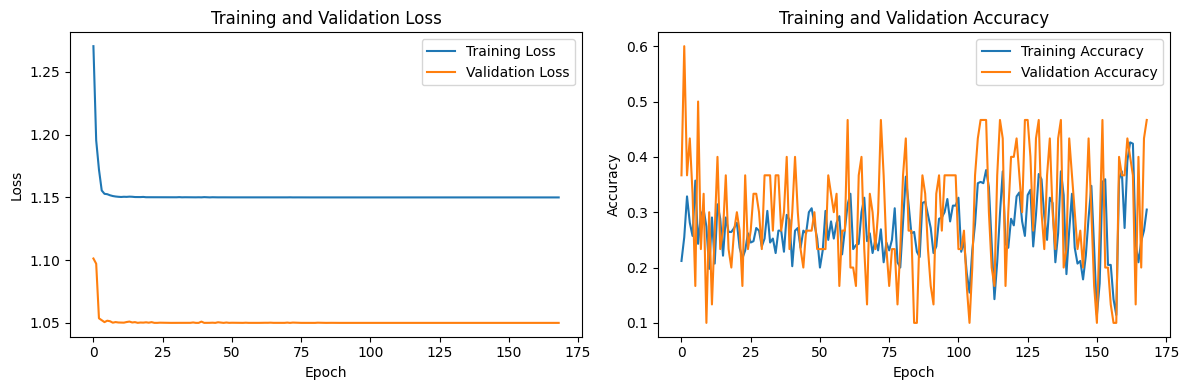

Epoch 1/200
14/14 [==============================] - 6s 389ms/step - loss: 1.4065 - accuracy: 0.0381 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 5s 375ms/step - loss: 1.4143 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 3/200
14/14 [==============================] - 5s 373ms/step - loss: 1.4143 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 4/200
14/14 [==============================] - 5s 376ms/step - loss: 1.4143 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 5/200
14/14 [==============================] - 5s 371ms/step - loss: 1.4143 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 6/200
14/14 [==============================] - 5s 373ms/step - loss: 1.4143 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 7/200
14/14 [==============================] - 5s 375ms/step - loss: 1.4143 - accuracy: 0.00

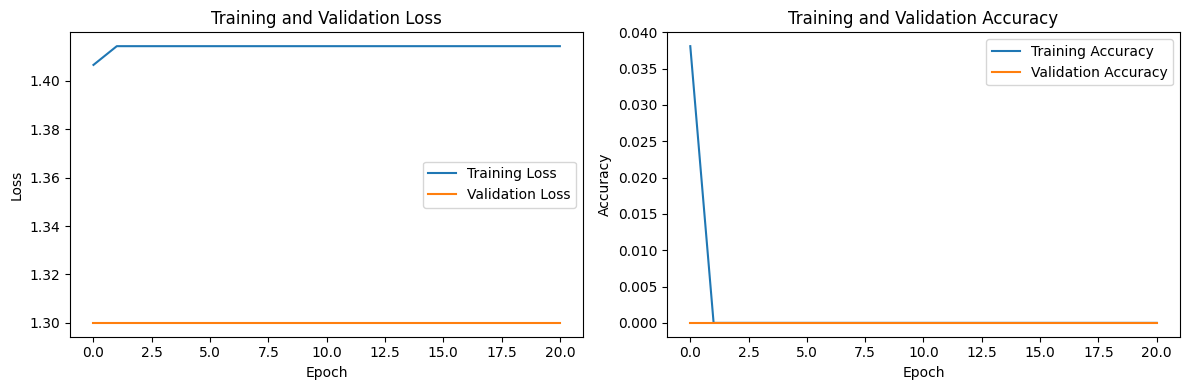

Epoch 1/200
14/14 [==============================] - 6s 378ms/step - loss: 1.3664 - accuracy: 0.4048 - val_loss: 1.2079 - val_accuracy: 0.1333
Epoch 2/200
14/14 [==============================] - 5s 370ms/step - loss: 1.2807 - accuracy: 0.2119 - val_loss: 1.1639 - val_accuracy: 0.3667
Epoch 3/200
14/14 [==============================] - 5s 359ms/step - loss: 1.2097 - accuracy: 0.2167 - val_loss: 1.0664 - val_accuracy: 0.1333
Epoch 4/200
14/14 [==============================] - 5s 362ms/step - loss: 1.1721 - accuracy: 0.3357 - val_loss: 1.0514 - val_accuracy: 0.3667
Epoch 5/200
14/14 [==============================] - 5s 361ms/step - loss: 1.1619 - accuracy: 0.2929 - val_loss: 1.0510 - val_accuracy: 0.2333
Epoch 6/200
14/14 [==============================] - 5s 364ms/step - loss: 1.1604 - accuracy: 0.1690 - val_loss: 1.0502 - val_accuracy: 0.4333
Epoch 7/200
14/14 [==============================] - 5s 359ms/step - loss: 1.1600 - accuracy: 0.2952 - val_loss: 1.0511 - val_accuracy: 0.2667

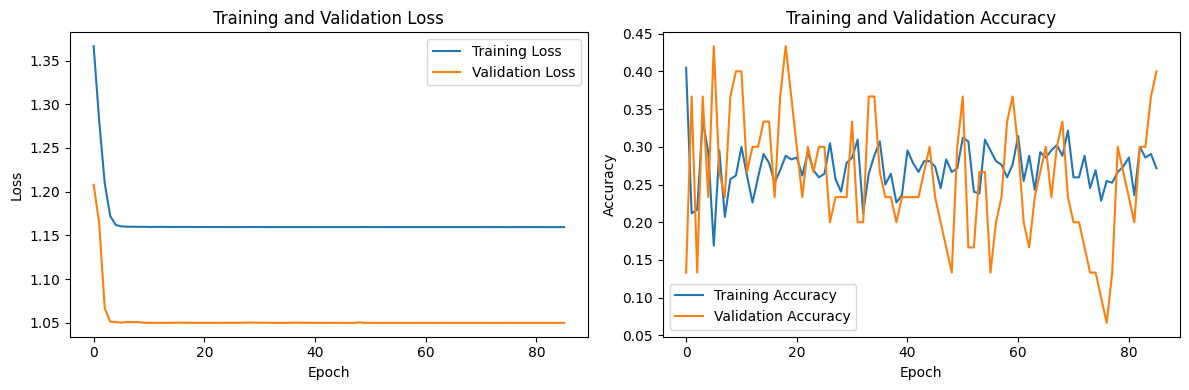

Epoch 1/200
14/14 [==============================] - 6s 370ms/step - loss: 1.3755 - accuracy: 0.5167 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 2/200
14/14 [==============================] - 5s 345ms/step - loss: 1.3905 - accuracy: 0.5548 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 3/200
14/14 [==============================] - 5s 347ms/step - loss: 1.3905 - accuracy: 0.5548 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 4/200
14/14 [==============================] - 5s 345ms/step - loss: 1.3905 - accuracy: 0.5548 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 5/200
14/14 [==============================] - 5s 345ms/step - loss: 1.3905 - accuracy: 0.5548 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 6/200
14/14 [==============================] - 5s 348ms/step - loss: 1.3905 - accuracy: 0.5548 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 7/200
14/14 [==============================] - 5s 345ms/step - loss: 1.3905 - accuracy: 0.5548 - val_loss: 1.3000 - val_accuracy: 0.6000

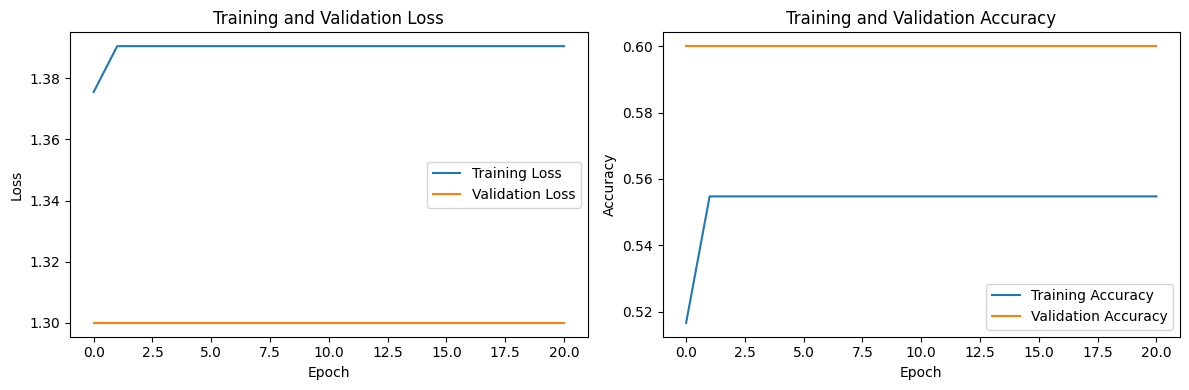

Epoch 1/200
14/14 [==============================] - 6s 364ms/step - loss: 1.3853 - accuracy: 0.0262 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 5s 349ms/step - loss: 1.4000 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 3/200
14/14 [==============================] - 5s 352ms/step - loss: 1.4000 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 4/200
14/14 [==============================] - 5s 350ms/step - loss: 1.4000 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 5/200
14/14 [==============================] - 5s 350ms/step - loss: 1.4000 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 6/200
14/14 [==============================] - 5s 352ms/step - loss: 1.4000 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 7/200
14/14 [==============================] - 5s 351ms/step - loss: 1.4000 - accuracy: 0.00

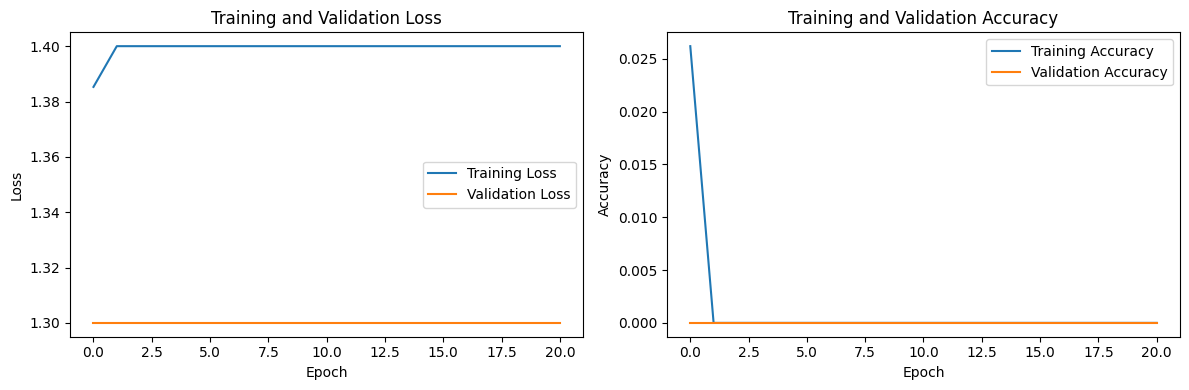

Epoch 1/200
14/14 [==============================] - 6s 361ms/step - loss: 1.3910 - accuracy: 0.5143 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 2/200
14/14 [==============================] - 5s 340ms/step - loss: 1.4048 - accuracy: 0.5476 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 3/200
14/14 [==============================] - 5s 342ms/step - loss: 1.4048 - accuracy: 0.5476 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 4/200
14/14 [==============================] - 5s 342ms/step - loss: 1.4048 - accuracy: 0.5476 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 5/200
14/14 [==============================] - 5s 340ms/step - loss: 1.4048 - accuracy: 0.5476 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 6/200
14/14 [==============================] - 5s 344ms/step - loss: 1.4048 - accuracy: 0.5476 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 7/200
14/14 [==============================] - 5s 342ms/step - loss: 1.4048 - accuracy: 0.5476 - val_loss: 1.3000 - val_accuracy: 0.6000

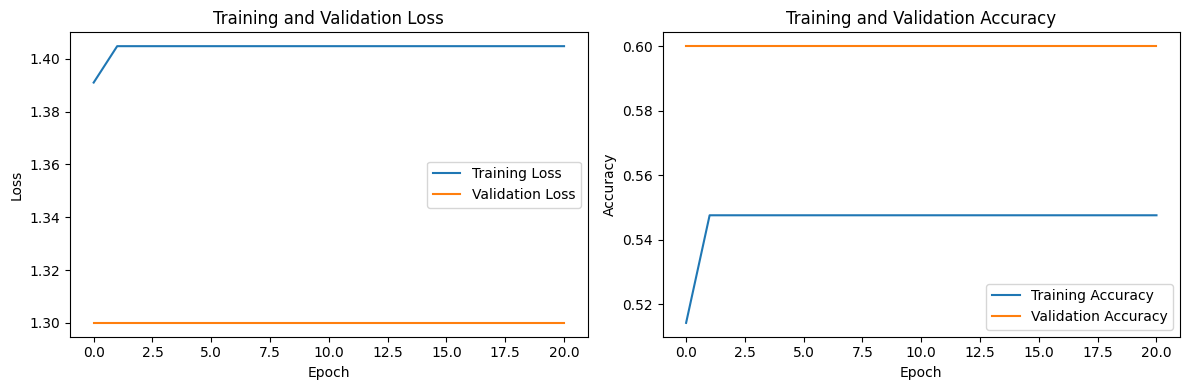

Epoch 1/200
14/14 [==============================] - 6s 355ms/step - loss: 1.4104 - accuracy: 0.0405 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 5s 337ms/step - loss: 1.4238 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 3/200
14/14 [==============================] - 5s 340ms/step - loss: 1.4238 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 4/200
14/14 [==============================] - 5s 340ms/step - loss: 1.4238 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 5/200
14/14 [==============================] - 5s 339ms/step - loss: 1.4238 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 6/200
14/14 [==============================] - 5s 339ms/step - loss: 1.4238 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 7/200
14/14 [==============================] - 5s 341ms/step - loss: 1.4238 - accuracy: 0.00

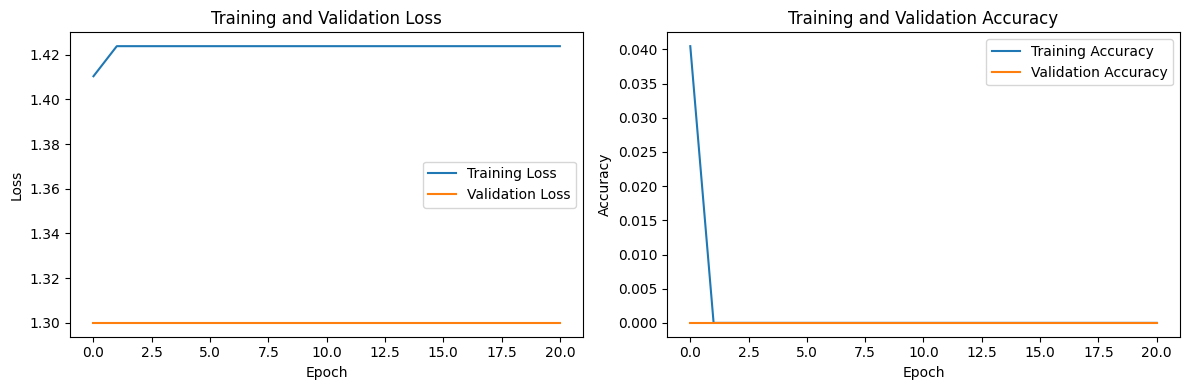

Epoch 1/200
14/14 [==============================] - 6s 355ms/step - loss: 1.3989 - accuracy: 0.5119 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 2/200
14/14 [==============================] - 5s 338ms/step - loss: 1.4143 - accuracy: 0.5429 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 3/200
14/14 [==============================] - 5s 336ms/step - loss: 1.4143 - accuracy: 0.5429 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 4/200
14/14 [==============================] - 5s 337ms/step - loss: 1.4143 - accuracy: 0.5429 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 5/200
14/14 [==============================] - 5s 338ms/step - loss: 1.4143 - accuracy: 0.5429 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 6/200
14/14 [==============================] - 5s 340ms/step - loss: 1.4143 - accuracy: 0.5429 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 7/200
14/14 [==============================] - 5s 338ms/step - loss: 1.4143 - accuracy: 0.5429 - val_loss: 1.3000 - val_accuracy: 0.6000

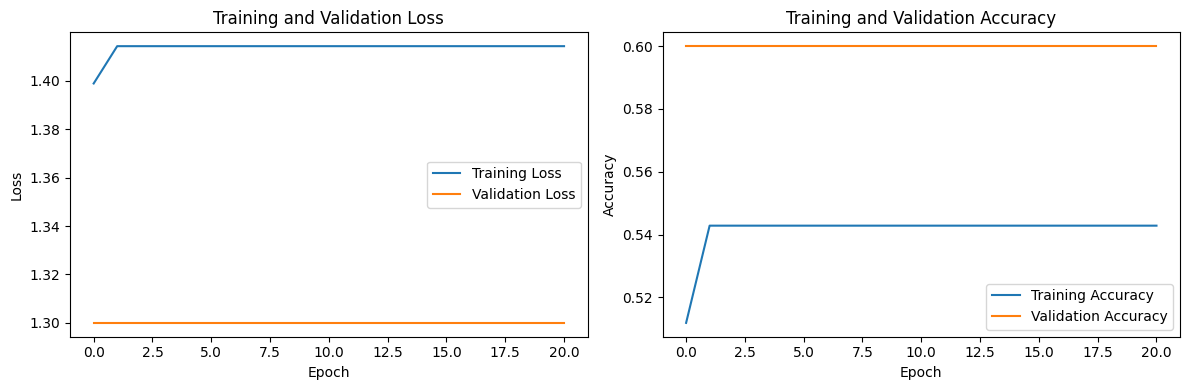

Epoch 1/200
14/14 [==============================] - 7s 416ms/step - loss: 1.4165 - accuracy: 0.4976 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 2/200
14/14 [==============================] - 6s 397ms/step - loss: 1.4286 - accuracy: 0.5357 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 3/200
14/14 [==============================] - 6s 395ms/step - loss: 1.4286 - accuracy: 0.5357 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 4/200
14/14 [==============================] - 6s 398ms/step - loss: 1.4286 - accuracy: 0.5357 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 5/200
14/14 [==============================] - 6s 399ms/step - loss: 1.4286 - accuracy: 0.5357 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 6/200
14/14 [==============================] - 6s 396ms/step - loss: 1.4286 - accuracy: 0.5357 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 7/200
14/14 [==============================] - 6s 394ms/step - loss: 1.4286 - accuracy: 0.5357 - val_loss: 1.3000 - val_accuracy: 0.6000

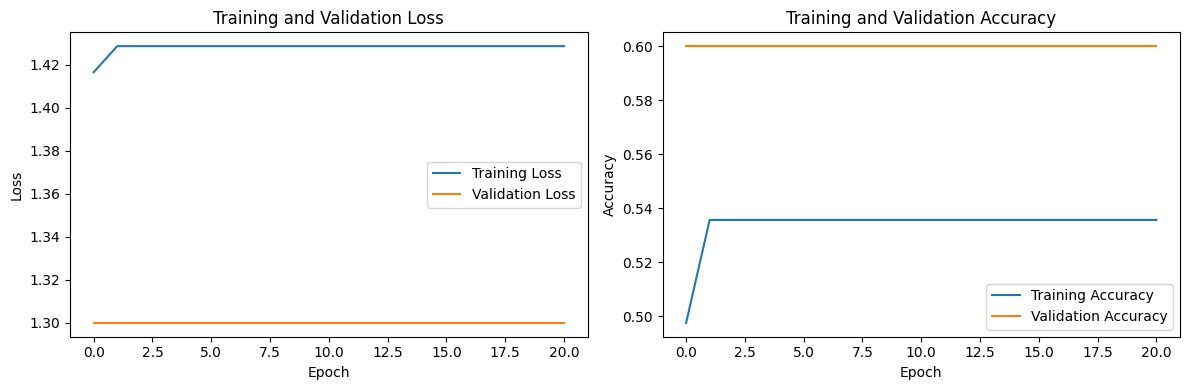

Epoch 1/200
14/14 [==============================] - 6s 404ms/step - loss: 1.3975 - accuracy: 0.5095 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 2/200
14/14 [==============================] - 5s 386ms/step - loss: 1.4095 - accuracy: 0.5452 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 3/200
14/14 [==============================] - 5s 387ms/step - loss: 1.4095 - accuracy: 0.5452 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 4/200
14/14 [==============================] - 5s 387ms/step - loss: 1.4095 - accuracy: 0.5452 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 5/200
14/14 [==============================] - 5s 383ms/step - loss: 1.4095 - accuracy: 0.5452 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 6/200
14/14 [==============================] - 5s 385ms/step - loss: 1.4095 - accuracy: 0.5452 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 7/200
14/14 [==============================] - 5s 387ms/step - loss: 1.4095 - accuracy: 0.5452 - val_loss: 1.3000 - val_accuracy: 0.6000

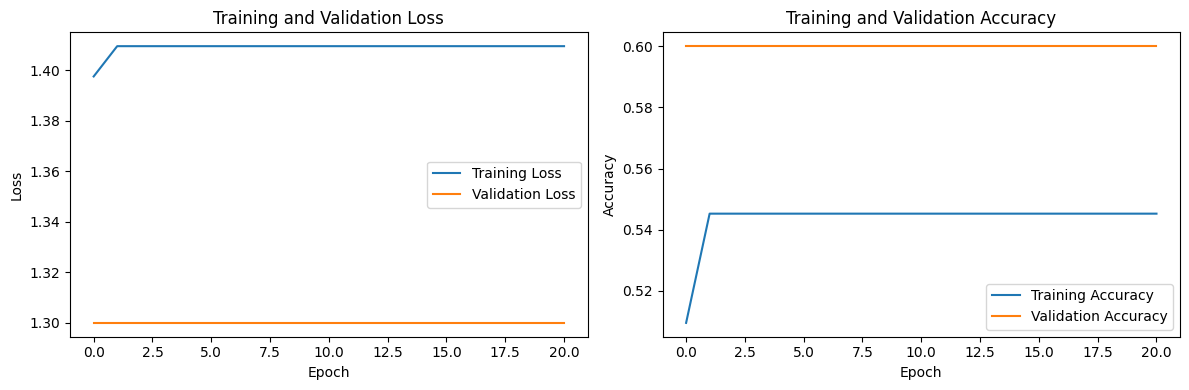

Epoch 1/200
14/14 [==============================] - 6s 391ms/step - loss: 1.3778 - accuracy: 0.5143 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 2/200
14/14 [==============================] - 5s 372ms/step - loss: 1.3905 - accuracy: 0.5548 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 3/200
14/14 [==============================] - 5s 373ms/step - loss: 1.3905 - accuracy: 0.5548 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 4/200
14/14 [==============================] - 5s 374ms/step - loss: 1.3905 - accuracy: 0.5548 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 5/200
14/14 [==============================] - 5s 374ms/step - loss: 1.3905 - accuracy: 0.5548 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 6/200
14/14 [==============================] - 5s 373ms/step - loss: 1.3905 - accuracy: 0.5548 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 7/200
14/14 [==============================] - 5s 372ms/step - loss: 1.3905 - accuracy: 0.5548 - val_loss: 1.3000 - val_accuracy: 0.6000

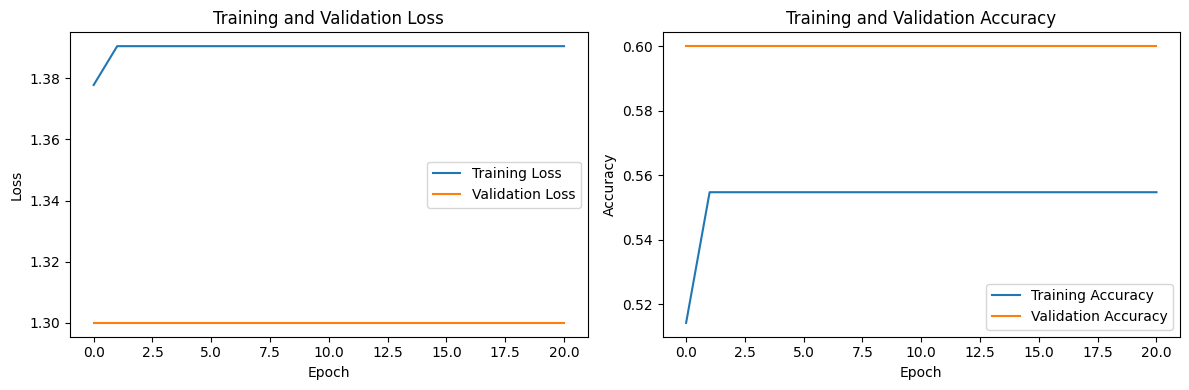

Epoch 1/200
14/14 [==============================] - 6s 384ms/step - loss: 1.3710 - accuracy: 0.1429 - val_loss: 1.2751 - val_accuracy: 0.2000
Epoch 2/200
14/14 [==============================] - 5s 364ms/step - loss: 1.3849 - accuracy: 0.1976 - val_loss: 1.2962 - val_accuracy: 0.2333
Epoch 3/200
14/14 [==============================] - 5s 368ms/step - loss: 1.3582 - accuracy: 0.3881 - val_loss: 1.2234 - val_accuracy: 0.2667
Epoch 4/200
14/14 [==============================] - 5s 367ms/step - loss: 1.2741 - accuracy: 0.2571 - val_loss: 1.1070 - val_accuracy: 0.4333
Epoch 5/200
14/14 [==============================] - 5s 366ms/step - loss: 1.1889 - accuracy: 0.2381 - val_loss: 1.0641 - val_accuracy: 0.4000
Epoch 6/200
14/14 [==============================] - 5s 369ms/step - loss: 1.1651 - accuracy: 0.2881 - val_loss: 1.0524 - val_accuracy: 0.5667
Epoch 7/200
14/14 [==============================] - 5s 367ms/step - loss: 1.1579 - accuracy: 0.3357 - val_loss: 1.0523 - val_accuracy: 0.3333

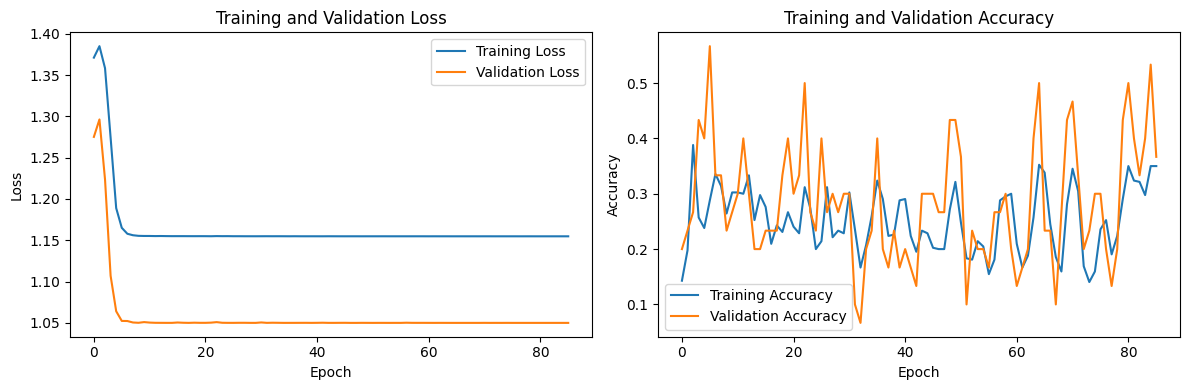

Epoch 1/200
14/14 [==============================] - 6s 371ms/step - loss: 1.3831 - accuracy: 0.5262 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 2/200
14/14 [==============================] - 5s 359ms/step - loss: 1.3952 - accuracy: 0.5524 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 3/200
14/14 [==============================] - 5s 355ms/step - loss: 1.3952 - accuracy: 0.5524 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 4/200
14/14 [==============================] - 5s 355ms/step - loss: 1.3952 - accuracy: 0.5524 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 5/200
14/14 [==============================] - 5s 352ms/step - loss: 1.3952 - accuracy: 0.5524 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 6/200
14/14 [==============================] - 5s 355ms/step - loss: 1.3952 - accuracy: 0.5524 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 7/200
14/14 [==============================] - 5s 352ms/step - loss: 1.3952 - accuracy: 0.5524 - val_loss: 1.3000 - val_accuracy: 0.6000

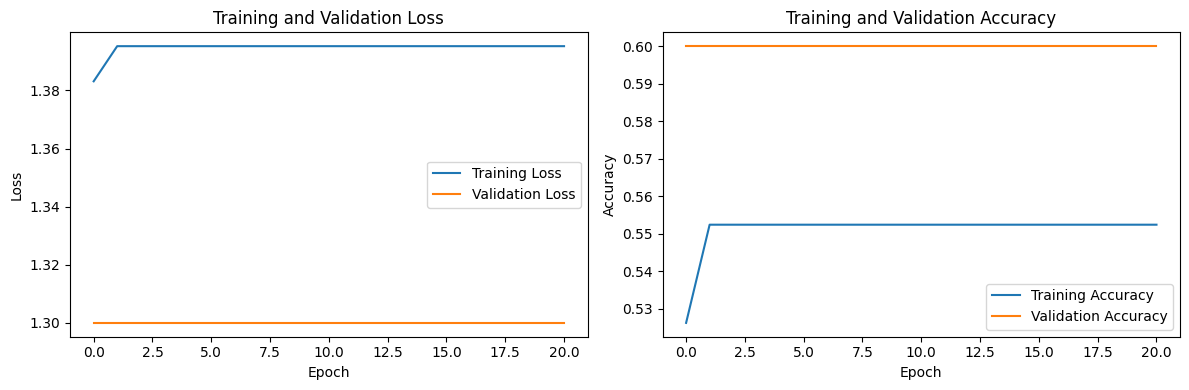

Epoch 1/200
14/14 [==============================] - 6s 367ms/step - loss: 1.3846 - accuracy: 0.0238 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 5s 350ms/step - loss: 1.4000 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 3/200
14/14 [==============================] - 5s 349ms/step - loss: 1.4000 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 4/200
14/14 [==============================] - 5s 350ms/step - loss: 1.4000 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 5/200
14/14 [==============================] - 5s 350ms/step - loss: 1.4000 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 6/200
14/14 [==============================] - 5s 351ms/step - loss: 1.4000 - accuracy: 0.0000e+00 - val_loss: 1.3000 - val_accuracy: 0.0000e+00
Epoch 7/200
14/14 [==============================] - 5s 353ms/step - loss: 1.4000 - accuracy: 0.00

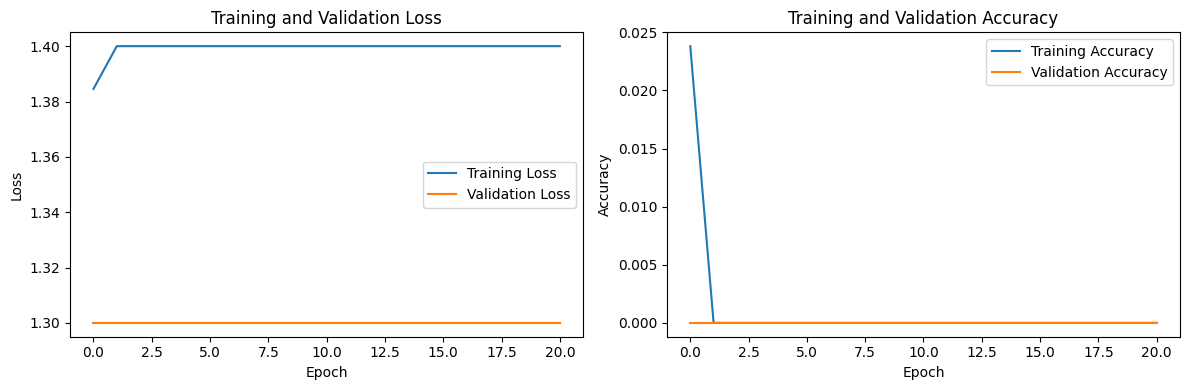

Epoch 1/200
14/14 [==============================] - 6s 359ms/step - loss: 1.3994 - accuracy: 0.5143 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 2/200
14/14 [==============================] - 5s 343ms/step - loss: 1.4143 - accuracy: 0.5429 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 3/200
14/14 [==============================] - 5s 347ms/step - loss: 1.4143 - accuracy: 0.5429 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 4/200
14/14 [==============================] - 5s 343ms/step - loss: 1.4143 - accuracy: 0.5429 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 5/200
14/14 [==============================] - 5s 342ms/step - loss: 1.4143 - accuracy: 0.5429 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 6/200
14/14 [==============================] - 5s 345ms/step - loss: 1.4143 - accuracy: 0.5429 - val_loss: 1.3000 - val_accuracy: 0.6000
Epoch 7/200
14/14 [==============================] - 5s 343ms/step - loss: 1.4143 - accuracy: 0.5429 - val_loss: 1.3000 - val_accuracy: 0.6000

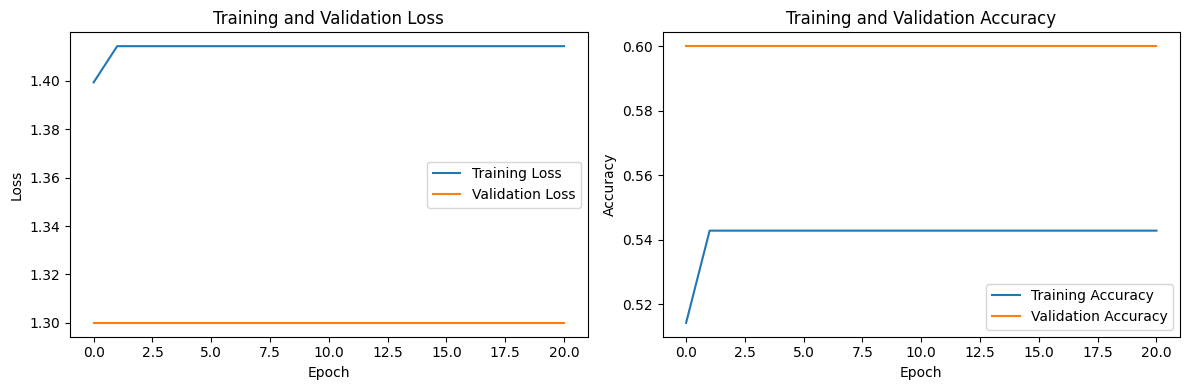

Average Classification Accuracy: 0.37555555555555553


In [293]:
# Reshape the data to fit the CNN input shape
input_shape = (participant_dde_features.shape[2], participant_dde_features.shape[3], 1)

# Initialize KFold cross-validation
kf = KFold(n_splits=15)
num_subjects=15

# Placeholder for storing accuracy scores
accuracy_scores = []

# Placeholder for storing loss history
loss_history = []

# Initialize the Early Stopping callback with adjusted patience and monitoring metric
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)


# Iterate through each subject as the test set
for train_subjects, test_subject in kf.split(np.arange(num_subjects)):
    # Select data for training and testing
    X_train = X[train_subjects].reshape(-1, *input_shape)
    y_train = Y[train_subjects].flatten()
    
    X_test = X[test_subjects].reshape(-1, *input_shape)
    y_test =Y[test_subjects].flatten()
    
    # Create the CNN model with different strategies
    model = create_cnn_model(input_shape)
    
    # Apply Early Stopping and Learning Rate Annealing
    early_stopping = EarlyStopping(patience=20, restore_best_weights=True)

    
    # Train the model with callbacks
    history = model.fit(X_train, y_train, epochs=200, batch_size=32,
                                validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
    

    # Append loss and accuracy history to the lists
    loss_history.append(history.history['loss'])

    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred_classes)
    accuracy_scores.append(accuracy)


    # Plot loss and accuracy curves for this fold
    plt.figure(figsize=(12, 4))

    # Plot training and validation loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Calculate the average accuracy
average_accuracy = np.mean(accuracy_scores)
print("Average Classification Accuracy:", average_accuracy)


In [292]:
input_shape

(29, 310, 1)

In [209]:
X.shape

(15, 30, 29, 310)

In [107]:
Y.shape

(15, 30)